In [80]:
# data retrieval
import requests
from zipfile import ZipFile
from io import BytesIO

# modeling and validation
from sklearn.model_selection import train_test_split, \
                                    cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier


from sklearn.metrics import accuracy_score, \
                            precision_score, \
                            recall_score, \
                            confusion_matrix, \
                            f1_score


# data storage and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from indoorplants.analysis import exploratory
from indoorplants.validation import crossvalidate, curves, boundaries
from indoorplants.analysis import wrangle
%matplotlib inline

# Step 0: Get Data
## Data Set Information: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

### The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

### There are four datasets: 
### 1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
### 2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
### 3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs). 
### 4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs). 
### The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM). 

### The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

# I will use the bank-additional-full.csv for this project

In [81]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip'
r = requests.get(url, stream=True)
zf = ZipFile(BytesIO(r.content))
table = pd.read_csv(zf.open('bank-additional/bank-additional-full.csv'),sep = ";")
table.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [82]:
# zf.namelist()

Input variables:
# bank client data:
1. `age` (numeric)
2. `job`: type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. `marital` : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. `education` (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. `default`: has credit in default? (categorical: 'no','yes','unknown')
6. `housing`: has housing loan? (categorical: 'no','yes','unknown')
7. `loan`: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8. `contact`: contact communication type (categorical: 'cellular','telephone') 
9.  `month`: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. `day_of_week`: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. `duration`: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12. `campaign`: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. `previous`: number of contacts performed before this campaign and for this client (numeric)
15. `poutcome`: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16. `emp.var.rate`: employment variation rate - quarterly indicator (numeric)
17. `cons.price.idx`: consumer price index - monthly indicator (numeric) 
18. `cons.conf.idx`: consumer confidence index - monthly indicator (numeric) 
19. `euribor3m`: euribor 3 month rate - daily indicator (numeric)
20. `nr.employed`: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21. `y` - has the client subscribed a term deposit? (binary: 'yes','no')

### `indoorplants` goals:


**General familiarity**
- gain a familiarity with _some_ functionality - do you like it? what would you make better?

**`center_scale_plot` bugs**
-  try to replicate the bug described [here](https://github.com/lermana/indoorplants/issues/16), and document the steps you took
- ditto for the bug [here](https://github.com/lermana/indoorplants/issues/10)
3. list any recommendations  you might have for fixing sense

**Expose `matplotlib` flexibility in plotting funcs**
- In many if not all of the available plotting functions, user cannot modify basic characteristics of the plots
- E.g. in `center_scale_plot`, it would be nice to be able to pass an argument for setting `xlim`
- Or `rot` for x-axis label rotation
- Identify key flexibility that is missing and try to add this functionality if you can

**Machine learning model fit**
- Use `crossvalidate.cv_score` to cross-validate your model; compare score results to `sklearn.cross_val_score`
- Experiment with the `curves.validation_curve` to tune a hyperparameter - what do you see?
- E.g. for tree-based models, could evaluate different values of `max_depth`; for logistic regression, `C`
- Validate model stability with `curves.learning_curve` - how did your model do?

# Step 1: Check Data
## 1.1 shape of data

- Apply `indoorplants` `wrangle.get_clean_df_index()` `wrangle.get_feature_size_by_class` to check shape of the marketing campaigns dataset

In [83]:
table.shape

(41188, 21)

In [84]:
wrangle.get_clean_df_index(table)

RangeIndex(start=0, stop=41188, step=1)

## 1.2 Duplicates

In [85]:
len(table[table.duplicated()])

12

We find 12 duplicated rows in the table. we will drop the duplicate values using `drop_duplicates`

In [86]:
table = table.drop_duplicates()

In [87]:
table.shape

(41176, 21)

## 1.3 Nulls
- checking if there are null values in the table using `indoorplants` `wangle.get_null_stats`

In [88]:
wrangle.get_null_stats(table)

,cnt,ratio
age,0,0
campaign,0,0
nr.employed,0,0
euribor3m,0,0
cons.conf.idx,0,0
cons.price.idx,0,0
emp.var.rate,0,0
poutcome,0,0
previous,0,0
pdays,0,0


We did find any nulls in the dataset.

## 1.4 Data types

In [89]:
table.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [90]:
table.columns = [c.replace(".", "_") for c in table.columns]

# Step 2: Explore the data 
- In this step, we focus on understanding data's features. We will be using `indoorplants.analysis.explantory` to visulize the dataset
## 2.1 y - output variable
- y is the output variable that lables yes/no subscribtion 

Let's set up response column: 1-yes, 0-no


In [91]:
table.y.value_counts()

no     36537
yes     4639
Name: y, dtype: int64

In [92]:
table.y = table.y.map(lambda _: 1 if _ == 'yes' else 0)

In [93]:
table.y.value_counts()

0    36537
1     4639
Name: y, dtype: int64

In [94]:
table.y.value_counts() / len(table)

0    0.887337
1    0.112663
Name: y, dtype: float64

#### Notes

The classes are imbalanced, appearing here at a ratio of roughly 9: 1 negative: postitive. 

## 2.2 input variables 
### 2.2.1 age 

In [95]:
table.age.isnull().sum()

0

In [96]:
table.age.nunique()

78

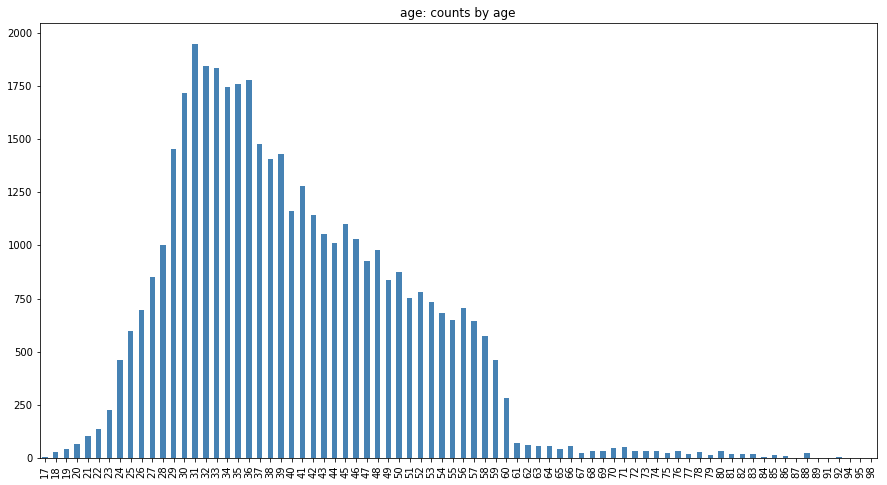

In [97]:
ax = table.age.value_counts().sort_index().plot.bar(figsize=(15, 8), color="steelblue")
ax.title.set_text('age: counts by age')

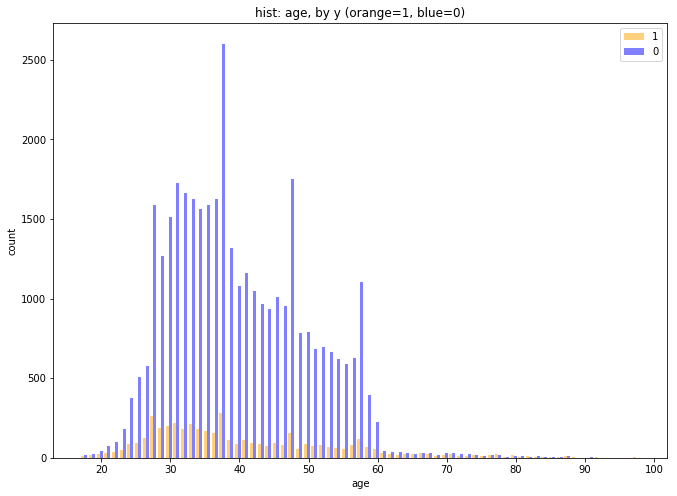

In [98]:
exploratory.feature_hist_by_class(table,'y','age',bins=73)

#### Notes
The age distributions of y = 1 and y  =  0 are quite different. The orange dist is flatter than the blue dist. This also shows that the data is imbalanced.  

- Experimenting with `xlim` `ylim` to check out the tail distribution

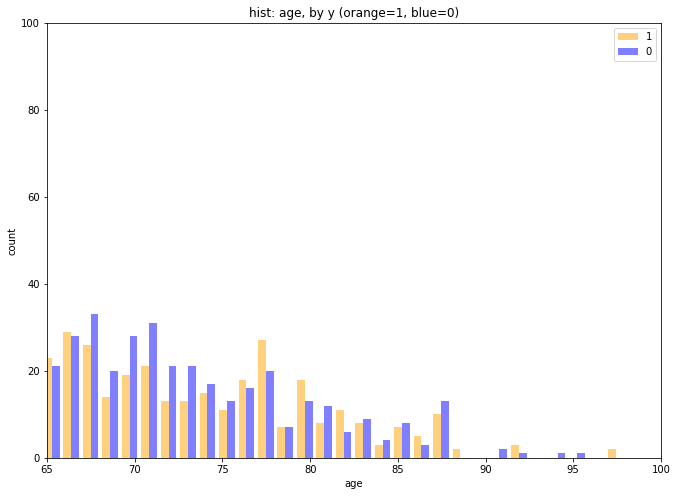

In [99]:
exploratory.feature_hist_by_class(table,'y','age',xlim=(65,100),ylim=(0,100),bins = 73)

The age data ranges from 17 to 98. It is left skewed. Let's take a close look of the data with `exploratory.enter_scale_plot`

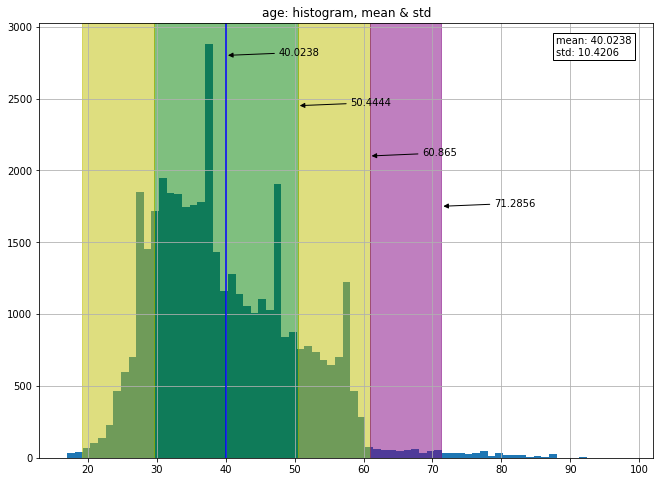

In [100]:
ax = exploratory.center_scale_plot(table.age, np.mean, np.std, bins=73)

- Experimenting with `xlim`, `ylim` arguments 

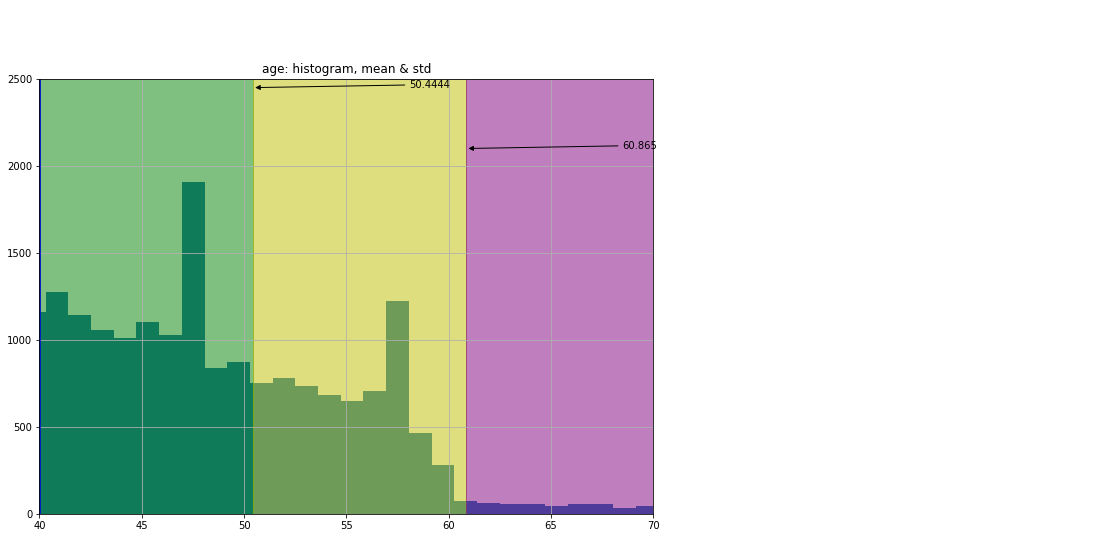

In [101]:
exploratory.center_scale_plot(table.age, np.mean, np.std,xlim=(40,70),ylim=(0,2500),bins=73)

The mean of the age variable is 40.0 with a std of 10.4. 3 std away from the mean is 71.2. 
Let's calculate the precentage of examples that are within 3 std of the mean:

In [102]:
(1-(len(table[table.age>71.2])/len(table.age)))*100

99.10384690110745

### Testing bug 16: exploratory.center_scale_plot can wig out when dealing with small values

In [103]:
table_test = table.age/10000

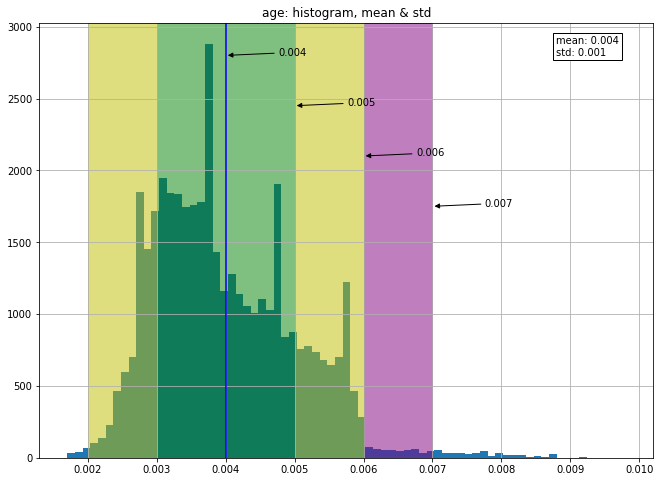

In [104]:
ax_test = exploratory.center_scale_plot(table_test, np.mean, np.std, bins=73)

### `bandn1` referenced before assignment... line 182 in exploratory if statement did not initialize `bandn1`

### Testing bug 10: bins = min(int(round(series.nunique(), -2) / 10), 100) will yield 0 if number of unique values in column is less than 50.

In [105]:
table_test2 = table.age[1:30]

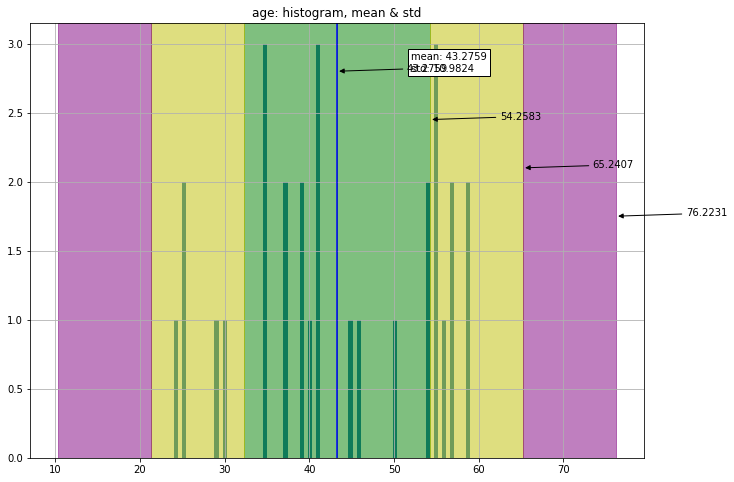

In [106]:
ax_test2 = exploratory.center_scale_plot(table_test2, np.mean, np.std, bins=73)

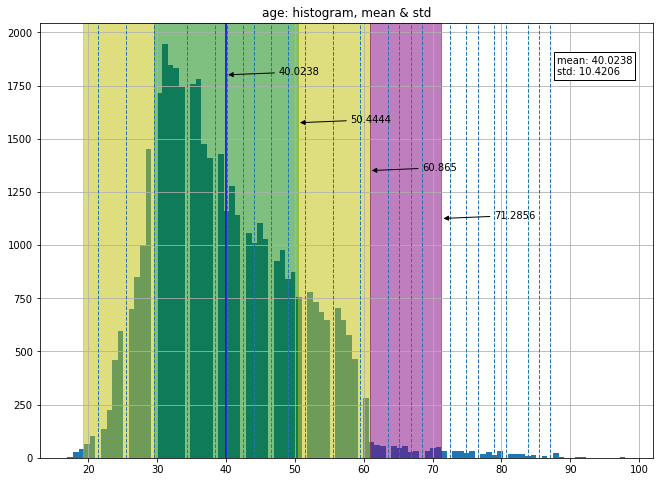

In [107]:
ax= exploratory.center_scale_with_peak_trough(table.age)

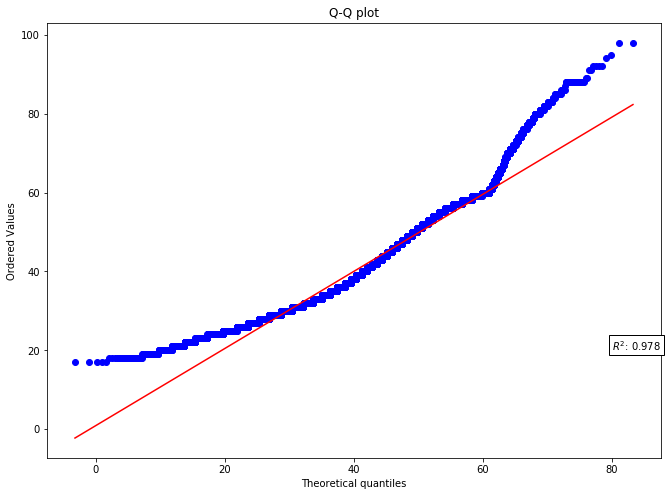

In [108]:
ax = exploratory.qq_plot(table.age.astype(int))

The Q-Q plot shows that the distribution of age fall along the line in the middle but curve off in the extremities. This means that the age data have more extreme values than would be expected in the normal distribution.

`exploratory.feature_value_counts_by_class`

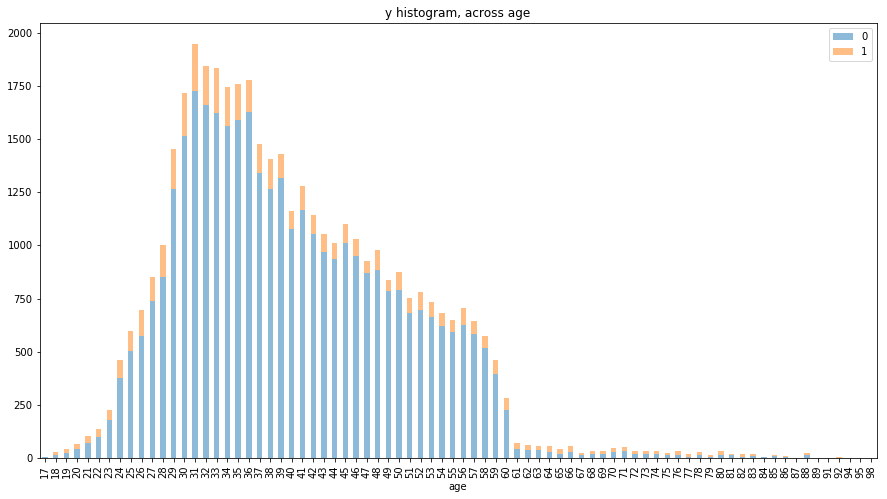

In [109]:
ax = exploratory.feature_value_counts_by_class(table, 'y', 'age', figsize=(15, 8))

Let's take a look at the ratio of subscribtion in each age. 

In [110]:
count0 = table.groupby('age')['y'].apply(lambda x: x[x == 0].count())

In [111]:
count1 = table.groupby('age')['y'].apply(lambda x: x[x == 1].count())

In [112]:
suscrib_r = count1.div(count0.add(count1))

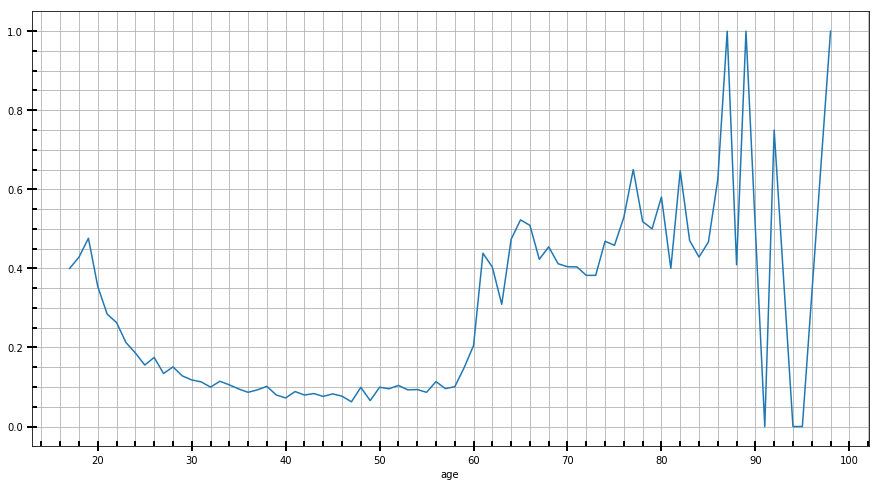

In [113]:
ax=suscrib_r.plot(figsize=(15, 8))
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='inout')
ax.tick_params(which='minor', length=5, width=2, direction='in')
# ax.set_xlim(20,80)
# ax.set_ylim(0.2,1)
ax.grid(which='both')

From this chart, even though the majority subscribers are from the age group of 20 to 60, the ratio of subcribtion of each age(from 20-60) are still lower that other ages. It is probably becaus of the extreme values over the tail.
### 2.2.2 job

In [114]:
table.job.isnull().sum()

0

In [115]:
table.job.nunique()

12

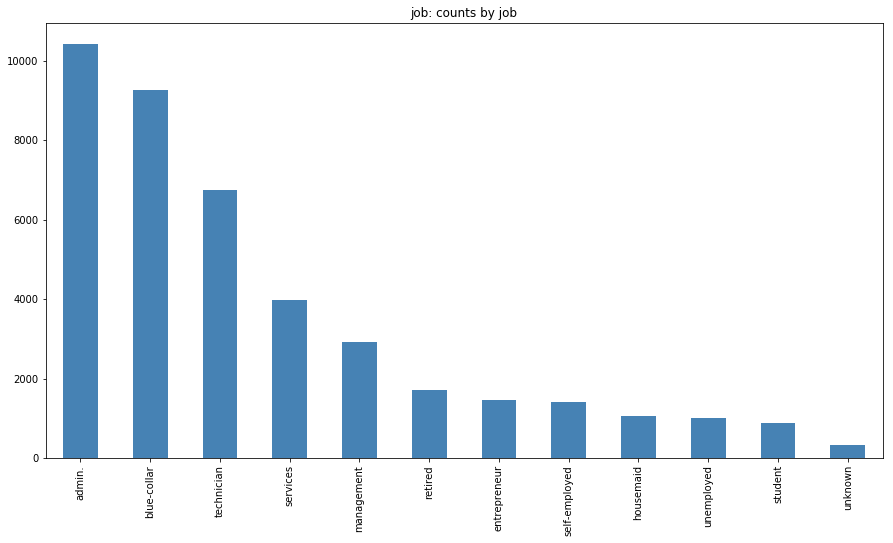

In [116]:
ax = table.job.value_counts().plot.bar(figsize=(15, 8), color="steelblue")
ax.title.set_text('job: counts by job')

(-0.5, 11.5)

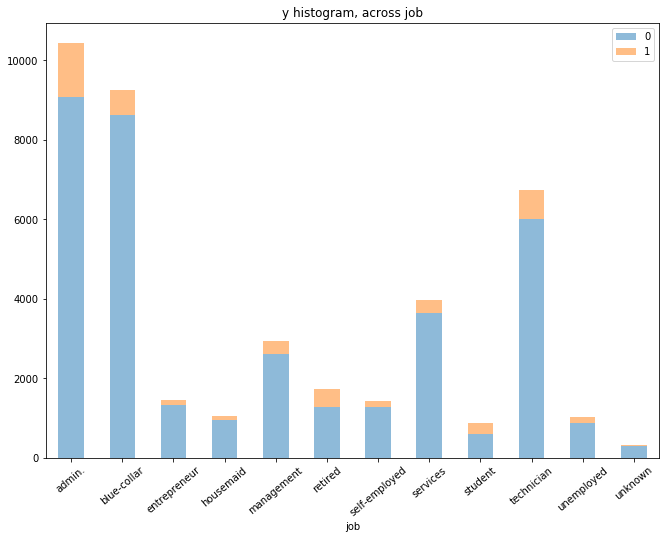

In [117]:
ax = exploratory.feature_value_counts_by_class(table, 'y','job', rot=40)
ax.set_xlim(None,None)

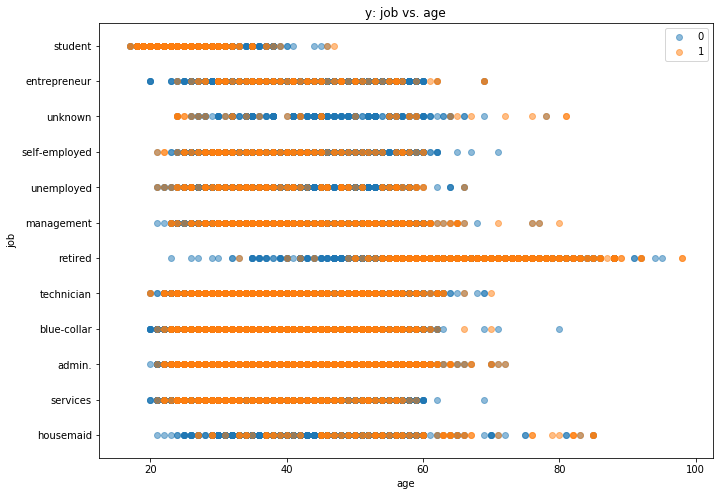

In [118]:
ax = exploratory.scatter_by_class(table, 'y', 'age', 'job')

`exploratory.scatter_by_class`:
Taking example of job: retired, we can see that people who are between 50 and 90 years old tend to subscribe the product. The more brownish regions in the above plot indicate an overlap between the classes, e.g. job: housemaid & age: 40

## 2.2.3 marital

In [119]:
table.marital.isnull().sum()

0

In [120]:
table.marital.nunique()

4

`wrangle.get_feature_size_by_class`

In [121]:
size_by_class_df = wrangle.get_feature_size_by_class(df=table,class_col='marital',features='y')

In [122]:
size_by_class_df

ratio
marital  y          
divorced 0  0.896769
         1  0.103231
married  0  0.898439
         1  0.101561
single   0  0.859910
         1  0.140090
unknown  0  0.850000
         1  0.150000

The table shows that within eahe Category, the class distributions are still imbalanced. 

`wrangle.is_feature_not_present_across_class`

In [123]:
wrangle.is_feature_not_present_across_class(size_by_class_df)

False

This shows that this feature is highly predictive.

`wrangle.is_feature_overweighted_towards_class`

In [124]:
wrangle.is_feature_overweighted_towards_class(size_by_class_df)

True

Ture indicated that there is one  categorical feature very strongly points towards a particular class value.

In [125]:
table.marital.describe()

count       41176
unique          4
top       married
freq        24921
Name: marital, dtype: object

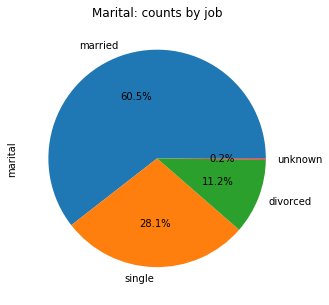

In [126]:
ax = table.marital.value_counts().plot.pie(figsize=(5, 5),autopct='%1.1f%%',)
ax.title.set_text('Marital: counts by job')

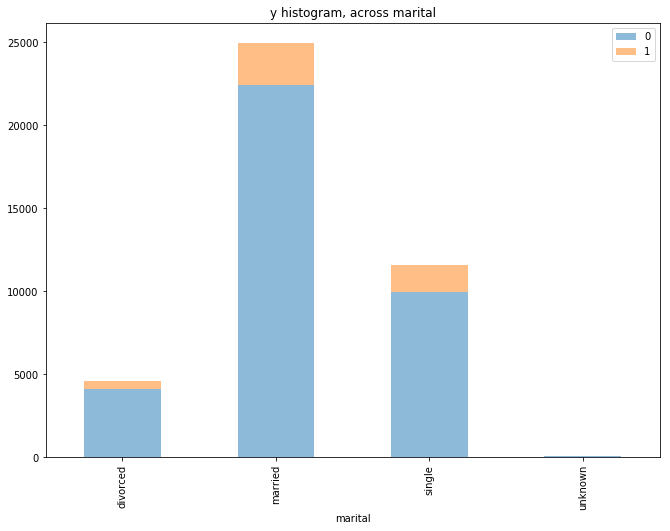

In [127]:
ax = exploratory.feature_value_counts_by_class(table,feature='marital',class_col='y')

### 2.2.4 education

In [128]:
table.education.isnull().sum()

0

In [129]:
table.education.nunique()

8

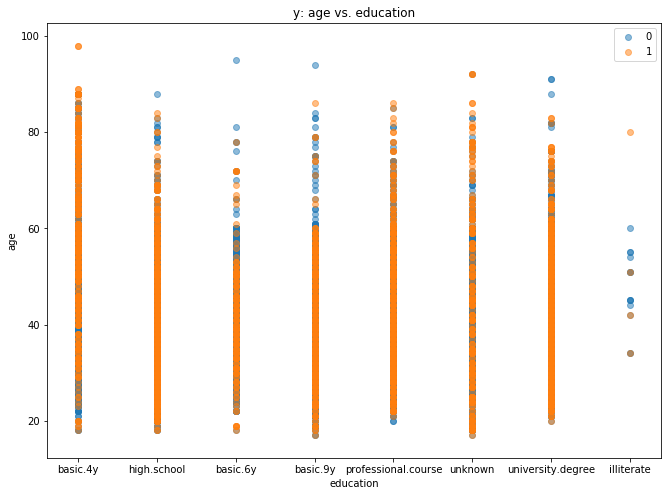

In [130]:
exploratory.scatter_by_class(table, 'y', 'education', 'age')

### 2.2.5 default, housing, loan, contract

In [131]:
table.default.isnull().sum()

0

In [132]:
table.default.nunique()

3

In [133]:
table.default.value_counts()

no         32577
unknown     8596
yes            3
Name: default, dtype: int64

In [134]:
table.housing.value_counts()

yes        21571
no         18615
unknown      990
Name: housing, dtype: int64

In [135]:
table.loan.value_counts()

no         33938
yes         6248
unknown      990
Name: loan, dtype: int64

In [136]:
table.contact.value_counts()

cellular     26135
telephone    15041
Name: contact, dtype: int64

### 2.2.6 month, day_of_week

In [137]:
table.month.value_counts()

may    13767
jul     7169
aug     6176
jun     5318
nov     4100
apr     2631
oct      717
sep      570
mar      546
dec      182
Name: month, dtype: int64

In [138]:
table.day_of_week.value_counts()

thu    8618
mon    8512
wed    8134
tue    8086
fri    7826
Name: day_of_week, dtype: int64

### 2.2.7 duration,campaign,pdays,previous

In [139]:
table.duration.head()

0    261
1    149
2    226
3    151
4    307
Name: duration, dtype: int64

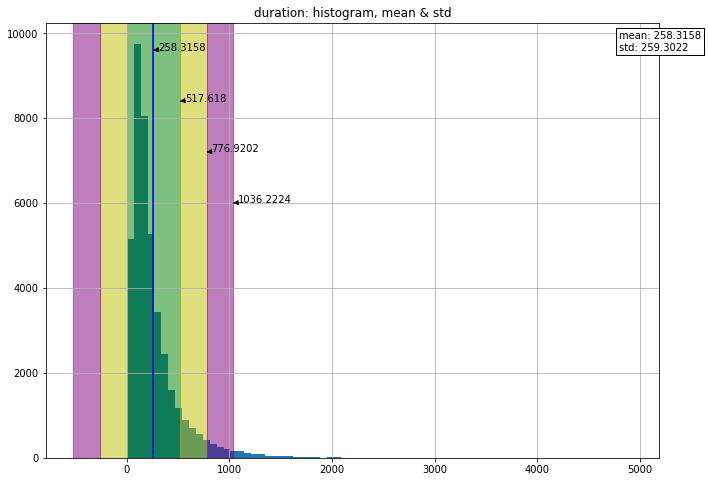

In [140]:
ax = exploratory.center_scale_plot(table.duration, np.mean, np.std, bins=73)

`feature_hist_by_class`

This is a pretty cool distribution - I wonder if this data's distribution is different depending on whether person is Subscribed?

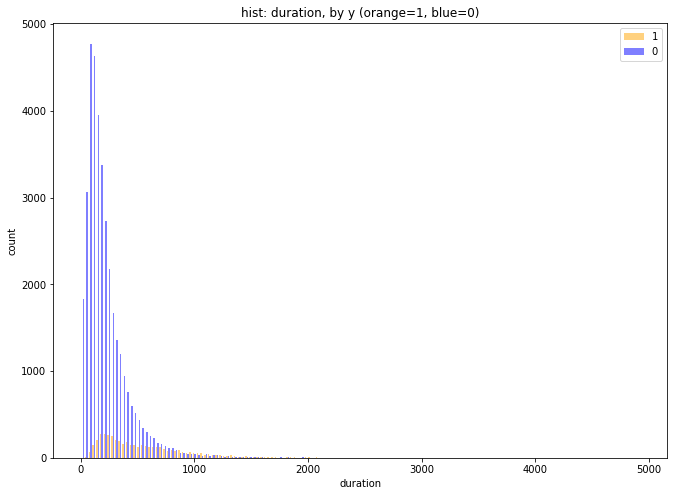

In [142]:
ax = exploratory.feature_hist_by_class(table,'y', "duration", bins=150)

We can tell that the duration distributions are very different. People who are subscribed has a fatter tail.

Let's take a look at the distributions of duration >= 800.

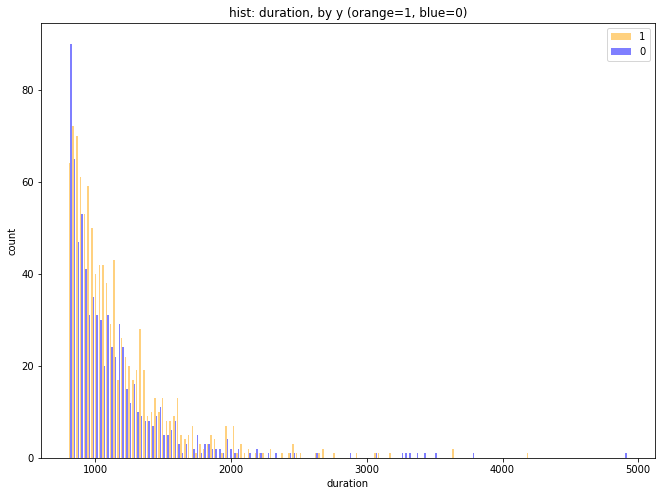

In [145]:
ax = exploratory.feature_hist_by_class(table[table.duration >= 800],'y', "duration", bins=150)

It is very interesting to see that the distributions >= 800 are very Similar.

`exploratory.box_plot_by_class`

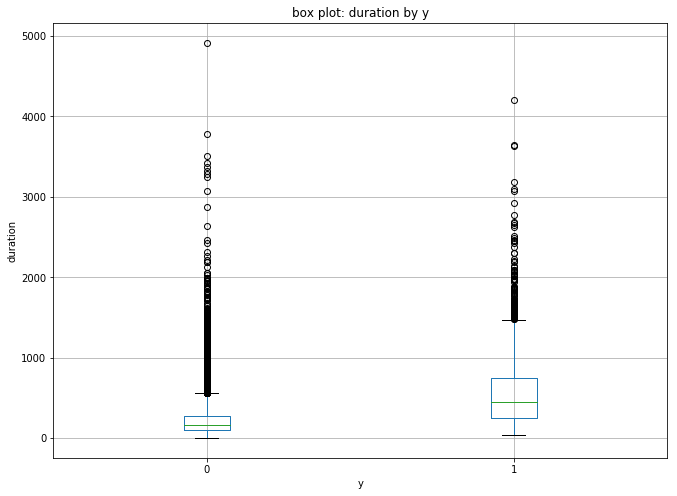

In [72]:
exploratory.box_plot_by_class(table, 'y','duration')

The boxplot indicates that people who are subscribed tends to have longer Contact duration period.

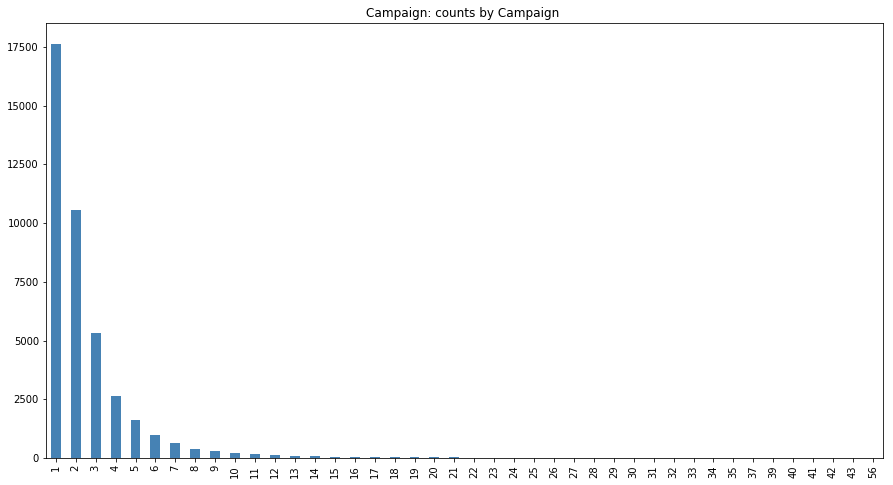

In [149]:
ax = table.campaign.value_counts().sort_index().plot.bar(figsize=(15, 8), color="steelblue")
ax.title.set_text('Campaign: counts by Campaign ')

In [150]:
table.pdays.value_counts()

999    39661
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64

In [151]:
table.previous.nunique()

8

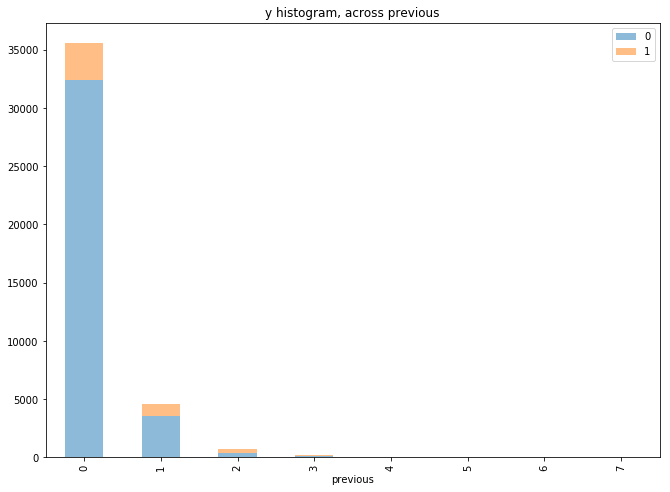

In [152]:
exploratory.feature_value_counts_by_class(table,feature='previous',class_col='y')

### 2.2.8 poutcome

In [153]:
table.poutcome.nunique()

3

In [154]:
table.poutcome.value_counts(normalize = True)*100

nonexistent    86.339130
failure        10.326404
success         3.334467
Name: poutcome, dtype: float64

### 2.2.9  emp.var.rate, cons.price.idx ,cons.conf.idx, euribor3m, nr.employed

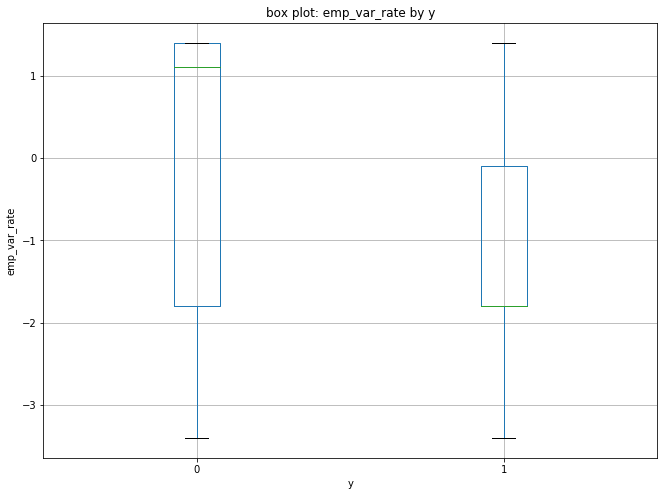

In [155]:
exploratory.box_plot_by_class(table, 'y','emp_var_rate')

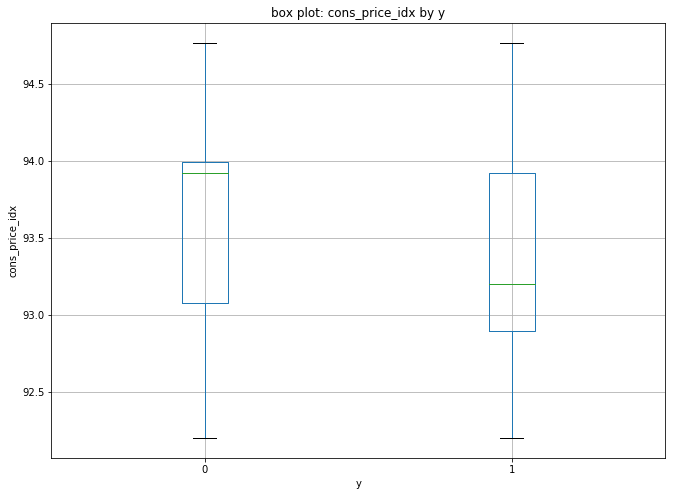

In [156]:
exploratory.box_plot_by_class(table, 'y','cons_price_idx')

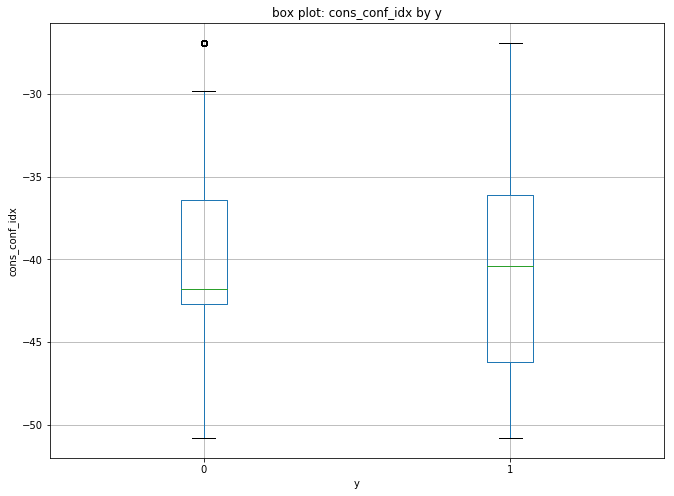

In [157]:
exploratory.box_plot_by_class(table, 'y','cons_conf_idx')

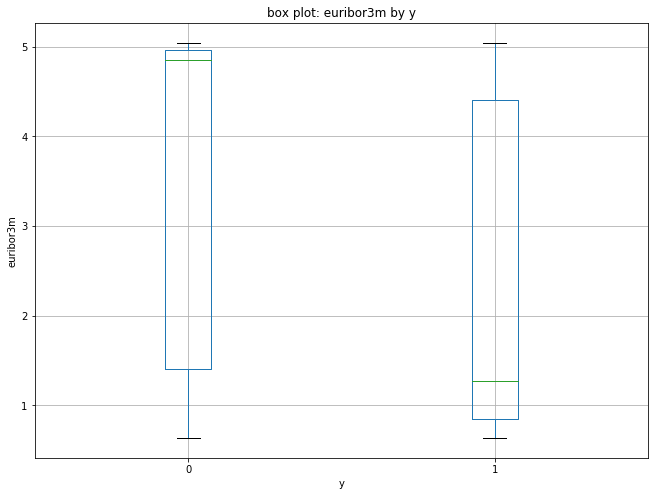

In [158]:
exploratory.box_plot_by_class(table, 'y','euribor3m')

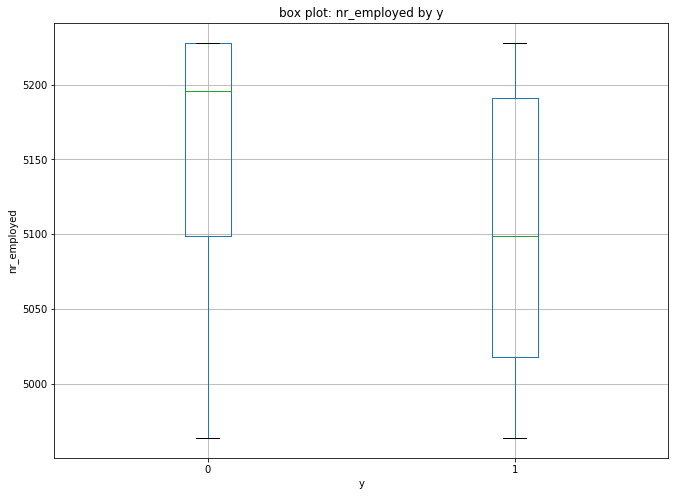

In [159]:
exploratory.box_plot_by_class(table, 'y','nr_employed')

# Step 3. Modeling


**Machine learning model fit**
- Use `crossvalidate.cv_score` to cross-validate your model; compare score results to `sklearn.cross_val_score`
- Experiment with the `curves.validation_curve` to tune a hyperparameter - what do you see?
- E.g. for tree-based models, could evaluate different values of `max_depth`; for logistic regression, `C`
- Validate model stability with `curves.learning_curve` - how did your model do?

In [160]:
table.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
y                   int64
dtype: object

#### From above, we choose One hot encoding for the categorical festures: 

["age","job","marital","education","default","housing", "loan","contact","month","day_of_week","duration","campaign","pdays","previous","poutcome","emp_var_rate","cons_price_idx","cons_conf_idx","euribor3m","nr_employed"]

In [161]:
obj_cols = ["job","marital","education","default","housing", "loan","contact","month","day_of_week","poutcome"]

In [162]:
one_hot_dfs = []
for col in obj_cols:
    one_hot_dfs.append(
            pd.get_dummies(
                    table[col],
                    prefix=f"is_{col}",
                    drop_first=True
        ))

In [163]:
one_hot_dfs[1].head()

,is_marital_married,is_marital_single,is_marital_unknown
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [164]:
one_hot = pd.concat(one_hot_dfs, axis=1)

In [165]:
one_hot.head()

,is_job_blue-collar,is_job_entrepreneur,is_job_housemaid,is_job_management,is_job_retired,is_job_self-employed,is_job_services,is_job_student,is_job_technician,is_job_unemployed,...,is_month_may,is_month_nov,is_month_oct,is_month_sep,is_day_of_week_mon,is_day_of_week_thu,is_day_of_week_tue,is_day_of_week_wed,is_poutcome_nonexistent,is_poutcome_success
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0


In [166]:
one_hot.iloc[:5, -5:]

,is_day_of_week_thu,is_day_of_week_tue,is_day_of_week_wed,is_poutcome_nonexistent,is_poutcome_success
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


### Preparing Data

In [169]:
def get_model_data(table, features,dummy):
    cols = ['y'] + features
    
    for_modeling = table[cols]
    
    to_dummy = list(filter(lambda _: _ in dummy, cols))
    
    one_hot_dfs =  pd.get_dummies(
                        table,
                        columns=to_dummy,
                        prefix=f"is_{col}",
                        drop_first=True)
               
#     one_hot = pd.concat(one_hot_dfs, axis=1)
    return one_hot_dfs



In [170]:
features =["age","job","marital","education","default","housing", "loan","contact","month","day_of_week","duration","campaign","pdays","previous","poutcome","emp_var_rate","cons_price_idx","cons_conf_idx","euribor3m","nr_employed"]

In [171]:
dummy = ["job","marital","education","default","housing", "loan","contact","month","day_of_week","poutcome"]

In [174]:
for_modeling_df = get_model_data(table,features,dummy)

In [173]:
for_modeling_df.columns = [c.replace(".", "_") for c in for_modeling_df.columns]

In [175]:
for_modeling_df.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'is_poutcome_blue-collar', 'is_poutcome_entrepreneur',
       'is_poutcome_housemaid', 'is_poutcome_management',
       'is_poutcome_retired', 'is_poutcome_self-employed',
       'is_poutcome_services', 'is_poutcome_student', 'is_poutcome_technician',
       'is_poutcome_unemployed', 'is_poutcome_unknown', 'is_poutcome_married',
       'is_poutcome_single', 'is_poutcome_unknown', 'is_poutcome_basic.6y',
       'is_poutcome_basic.9y', 'is_poutcome_high.school',
       'is_poutcome_illiterate', 'is_poutcome_professional.course',
       'is_poutcome_university.degree', 'is_poutcome_unknown',
       'is_poutcome_unknown', 'is_poutcome_yes', 'is_poutcome_unknown',
       'is_poutcome_yes', 'is_poutcome_unknown', 'is_poutcome_yes',
       'is_poutcome_telephone', 'is_poutcome_aug', 'is_poutcome_dec',
       'is_poutcome_jul', 'is_poutcom

In [176]:
X_model = [col for col in for_modeling_df.columns if col != 'y']

In [177]:
for_modeling_df.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,is_poutcome_may,is_poutcome_nov,is_poutcome_oct,is_poutcome_sep,is_poutcome_mon,is_poutcome_thu,is_poutcome_tue,is_poutcome_wed,is_poutcome_nonexistent,is_poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,1,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,1,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,1,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,1,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,1,0,0,0,1,0


### preparing data  for cross validation

In [185]:
cv, final = train_test_split(for_modeling_df.index, test_size=.20, random_state=1,
                                         stratify=for_modeling_df.y)

In [186]:
# for_modeling = for_modeling_df.loc[cv,:]

In [187]:
final = for_modeling_df.loc[final,:]

In [188]:
# for_modeling.shape

In [189]:
final.shape

(8236, 54)

# NO.1 Random Forest Classification
### 1.  Comparing `crossvalidate` and `sklearn`, Accuracy , Precision, Recall 
### 2.  Exercise  with `indoorplants.curves` 
### 3.  Hyperparameter Tuning the Random Forest

#### `crossvalidate.cv_score`

In [190]:
for_modeling_df = for_modeling_df.loc[cv, :]

In [191]:
for_modeling_df.shape

(32940, 54)

In [195]:
# recall_score()

In [193]:
results = crossvalidate.cv_score(model_obj=RandomForestClassifier(n_estimators=100,
                                                                  class_weight='balanced_subsample'),
                                 X=for_modeling_df[X_model],
                                 y=for_modeling_df.y,
                                 score_funcs=[accuracy_score,
                                              precision_score,
                                              recall_score],
                                 random_state=0)

In [194]:
results

mean       std
accuracy_score  train  0.999992  0.000017
                test   0.908743  0.003126
precision_score train  1.000000  0.000000
                test   0.664137  0.020905
recall_score    train  0.999933  0.000151
                test   0.383996  0.021779

#### Analysis

We've trained and tested a Random Forest classifier with 2 hyper parameters passed:
- `n_estimators`: "n_estimators represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the sweet spot."
- `class_weight`: When using RandomForestClassifier a useful setting is class_weight=balanced wherein classes are automatically weighted inversely proportional to how frequently they appear in the data. 

**_Accuracy score_**: The model seems to be overfitted. We are achieving almost 100% of accuracy on training, but 91% of accuracy on testing.

**_precision score_**: calculated as TP/(TP+FP). This score discribes how careful the model is on predictiong positive results. There are a lot discrepancy between the training and testing precision scores.

**_recall score_**: calculated as TP/(TP+FN). Model predicted positive over emparical positive.  we are looking at how thorough the model is in catching positive instances. The testing model fail to catch almost 60% of posiitive instances. 


In [197]:
for_modeling_df.y.value_counts(normalize=True)

0    0.887341
1    0.112659
Name: y, dtype: float64

The dataset is imbalanced.

In [224]:
from functools import partial, update_wrapper

In [225]:
recall_neg_class = partial(recall_score, pos_label=0)

In [226]:
update_wrapper(recall_neg_class, recall_score)

functools.partial(<function recall_score at 0x1a20f75620>, pos_label=0)

In [227]:
recall_neg_class.__name__ = "recall_neg_class"

In [228]:
results_neg = crossvalidate.cv_score(model_obj=RandomForestClassifier(n_estimators=100,
                                                                  class_weight='balanced_subsample'),
                                 X=for_modeling_df[X_model],
                                 y=for_modeling_df.y,
                                 score_funcs=[accuracy_score,
                                              precision_score,
                                              recall_score,
                                              recall_neg_class],
                                 random_state=0)

In [229]:
results_neg

mean       std
accuracy_score   train  1.000000  0.000000
                 test   0.909290  0.002478
precision_score  train  1.000000  0.000000
                 test   0.667462  0.017814
recall_score     train  1.000000  0.000000
                 test   0.388579  0.022824
recall_neg_class train  1.000000  0.000000
                 test   0.975401  0.002129

We can see that the model is predicting almost everything as negative class

### compare score results to `sklearn.cross_val_score`

In [230]:
RFC = RandomForestClassifier(n_estimators=100,class_weight='balanced_subsample',random_state=0)

In [231]:
RFC = RFC.fit(for_modeling_df[X_model], for_modeling_df.y)

In [232]:
RFC.predict(for_modeling_df[X_model].head())

array([0, 0, 0, 0, 0])

In [233]:
res = RFC.predict_proba(for_modeling_df[X_model].head())

In [234]:
res

array([[0.98, 0.02],
       [0.86, 0.14],
       [0.94, 0.06],
       [0.92, 0.08],
       [0.98, 0.02]])

In [252]:
# list(map(lambda x: 5 * round(float(x)/5, 2), res[:, 1]))

## Comparing Scores

#### Accruacy

In [236]:
scores_a = cross_val_score(RFC, X=for_modeling_df[X_model],
                           y=for_modeling_df.y,cv = 10, scoring='accuracy')

In [237]:
scores_a.mean()

0.9094416189468528

#### Precision

In [238]:
scores_p = cross_val_score(RFC, X=for_modeling_df[X_model],y=for_modeling_df.y,cv = 10, scoring='precision')

In [239]:
scores_p.mean()

0.6683945550611303

#### Recall

In [240]:
scores_r = cross_val_score(RFC, X=for_modeling_df[X_model],y=for_modeling_df.y,cv = 10, scoring='recall')

In [241]:
scores_r.mean()

0.3907283424629742

#### Notes:
_Accruacy  Score:_

`Indoorplants.crossvalidate`:0.908743 , `sklearn.cross_val_score`:0.9094416189468528

_Precision Score:_

`Indoorplants.crossvalidate`:0.664137 , `sklearn.cross_val_score`:0.6683945550611303

_Recall Score:_

`Indoorplants.crossvalidate`:0.383996 , `sklearn.cross_val_score`:0.3907283424629742


The resultes are pretty close. 


## Exercise with indoorplants.curves


## Tuning Hyperparameters

### `max_depth`
"max_depth represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data. We fit each decision tree with depths ranging from 1 to 32 and plot the training and test errors."

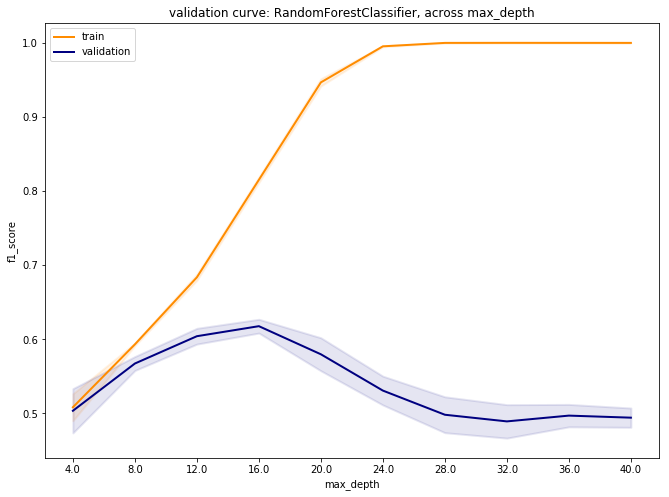

In [167]:
curves.validation_curve(model_type=RandomForestClassifier,
                        X=for_modeling_df[X_model],
                        y=for_modeling_df.y,
                        param_name='max_depth',
                        param_range=np.linspace(4, 40, 10),
                        other_params={'class_weight':'balanced_subsample',
                                      'n_estimators':100},
                        score=f1_score)

I am going to continue validation with a `max_depth` of 16. It has the highest validation f1_score. And there does appear to be a gain in validation performance between a `max_depth` of 12 and 16. As max_depth increases, the train and test scores diverge, which is a good sign of overfitting.

### `n_estimators`: 
"n_estimators represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the sweet spot."


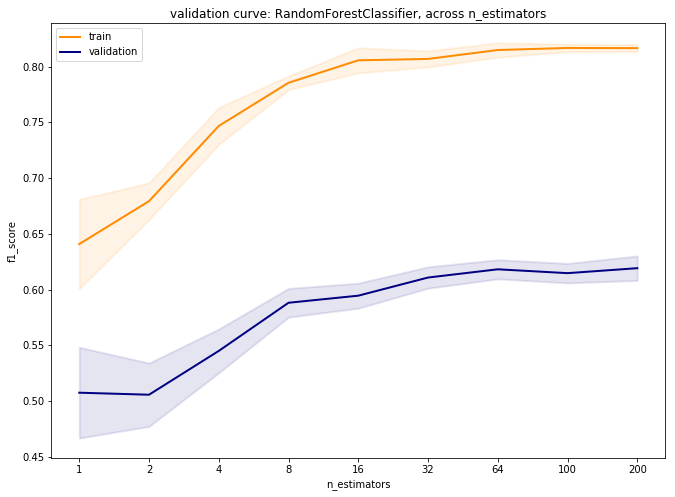

In [260]:
curves.validation_curve(model_type=RandomForestClassifier,
                        X=for_modeling_df[X_model],
                        y=for_modeling_df.y,
                        param_name='n_estimators',
                        param_range=[1, 2, 4, 8, 16, 32, 64, 100, 200],
                        other_params={'class_weight':'balanced_subsample',
                                      'max_depth':16},
                        score=f1_score)

Let `n_estimators` to be >32 would be a efficient choice for the model. I will use 50 to move forward.

### `min_samples_split` 
"min_samples_split represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, each tree in the forest becomes more constrained as it has to consider more samples at each node. Here we will vary the parameter from 10% to 100% of the samples"

In [278]:
min_samples_splits = np.linspace(.01, 1.0, 10, endpoint=True)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-sco

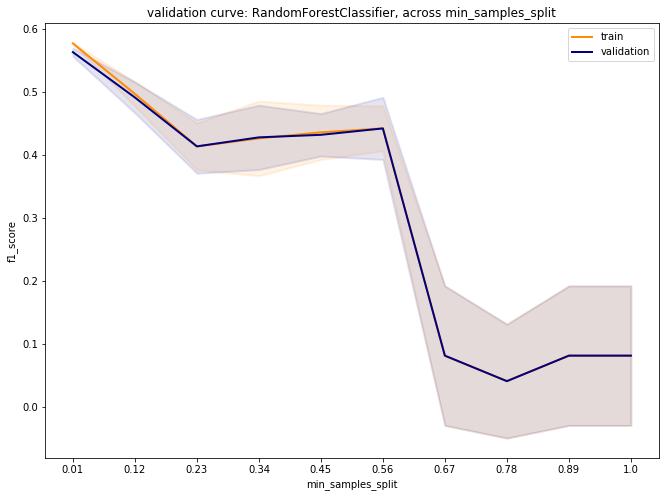

In [279]:
curves.validation_curve(model_type=RandomForestClassifier,
                        X=for_modeling_df[X_model],
                        y=for_modeling_df.y,
                        param_name='min_samples_split',
                        param_range=min_samples_splits,
                        other_params={'class_weight':'balanced_subsample',
                                      'max_depth':16,
                                      'n_estimators':60},
                        score=f1_score)

## Learning Curve

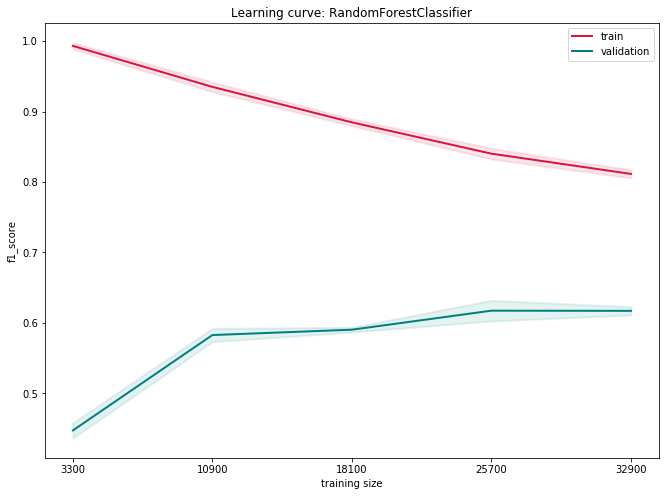

In [269]:
curves.learning_curve(model_type=RandomForestClassifier,
                      X=for_modeling_df[X_model],
                      y=for_modeling_df.y,
                      model_params={'class_weight':'balanced_subsample',
                                    'n_estimators':60,
                                    "max_depth": 16},
                      score=f1_score)

## Calibration_curve

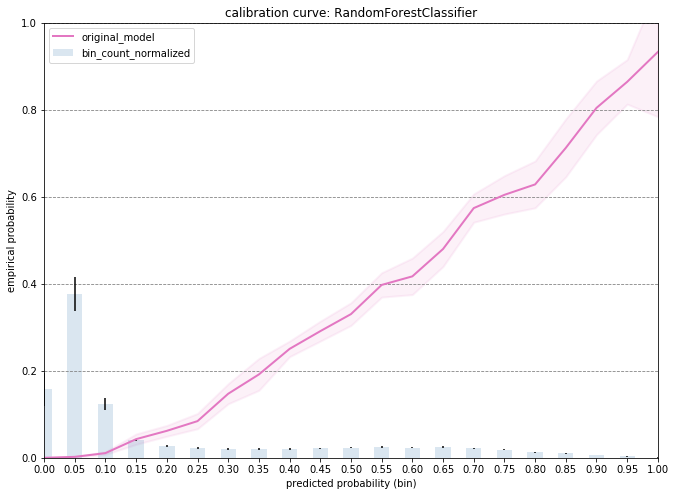

In [270]:
curves.calibration_curve(model_type=RandomForestClassifier,
                         X=for_modeling_df[X_model],
                         y=for_modeling_df.y,
                         model_params={'class_weight':'balanced_subsample',
                                       'n_estimators':60,
                                       "max_depth": 16})

##  Confusion Matrix

In [271]:
C_Mtx = crossvalidate.cv_conf_mat(model_obj=RandomForestClassifier(n_estimators=60,
                                                               class_weight='balanced_subsample',
                                                               max_depth=16),
                              X=for_modeling_df[X_model],
                              y=for_modeling_df.y,
                              splits=3)

In [272]:
C_Mtx

neg_pred  pos_pred
1 neg_true      9014       729
  pos_true       357       880
2 neg_true      8987       756
  pos_true       341       896
3 neg_true      8928       815
  pos_true       356       881

In [273]:
results = crossvalidate.cv_score(model_obj=RandomForestClassifier(n_estimators=60,
                                                                  class_weight='balanced_subsample',
                                                                  max_depth=16),
                                 X=for_modeling_df[X_model],
                                 y=for_modeling_df.y,
                                 score_funcs=[accuracy_score,
                                              precision_score,
                                              recall_score],
                                 random_state=0)

In [274]:
results

mean       std
accuracy_score  train  0.948975  0.001888
                test   0.896478  0.004217
precision_score train  0.693979  0.008260
                test   0.529462  0.013865
recall_score    train  0.978914  0.001338
                test   0.736457  0.022633

# NO.2 Logistic Regression
#### tune hyperparameter `C` 
`C` : Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

In [131]:
a = np.linspace(1,10,10)
a

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

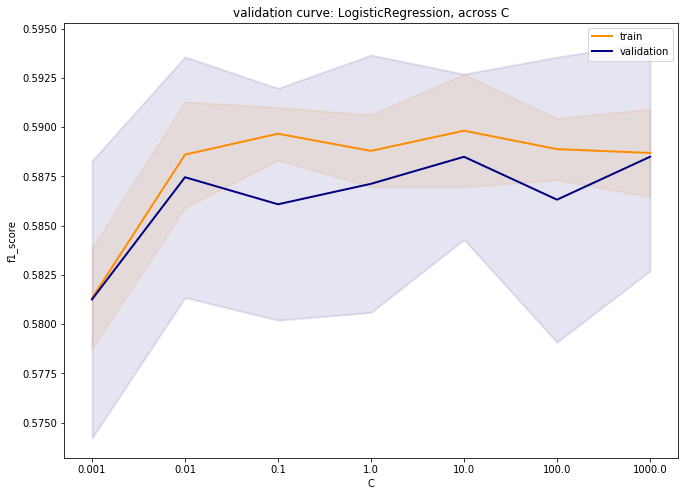

In [225]:
ax = curves.validation_curve(for_modeling_df[X_model], for_modeling_df.y, f1_score, LogisticRegression,
                             "C", [10**x for x in range(-3, 4)],
                             other_params={"solver": "lbfgs", "max_iter": 10**5, "class_weight": "balanced"})                             

#### Analysis
The Logistic regression classifiication seems to perform worse than the random forests classifier. The validation curve never reaches 60%.

Moreover, the f1_scores do not change much when `C` exceeds 0.01. We will use `C`  = 1 .

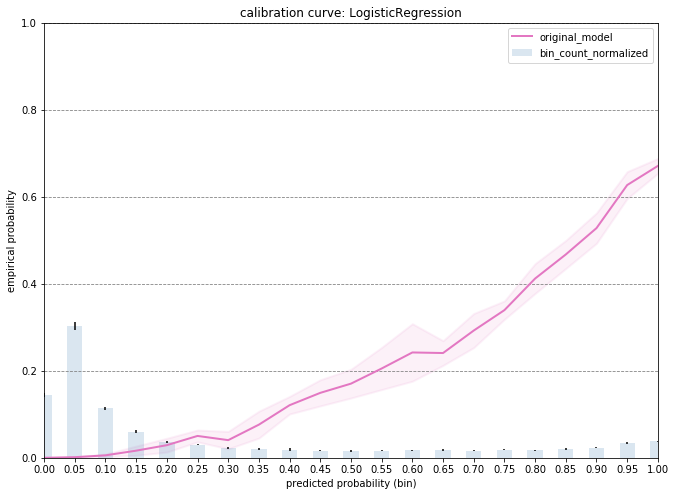

In [275]:
ax = curves.calibration_curve(for_modeling_df[X_model], for_modeling_df.y,
                              LogisticRegression,
                              model_params={"solver": "lbfgs", "max_iter": 10**5, "C": 1, "class_weight": "balanced"})                             

The calibration curve shows that the logistic regression classifier is overconfident with its predicion. When it predicts 100% probability to be right, the empirical probability is only around 70%. 

# Step 4: Conculsion 

The goal of this project is to build prediction model to help the bank's marketing team to determine subscription likelihood of a customer. So the marketing team could make a better decision on the target marketing group. 

I obtained the dataset from UCI Machine Learning Repository. The data I used has 41188 examples and 20 features. The analysis follows 3 steps including: checking data, exploring data, and modeling. I used library `indoorplants` for most of the analysis. 

In step 1, I checked the shape of the data and datatypes. I dropped duplicates and nulls in the data to make sure the data is clean and well formed. 

Then, I started to learn the characteristics of the data. The classification goal to predict if a client will subscribe the product(bank term deposit) or not. `y`, therefore, is the response variable. 1 indicates subscribed and 0 indicates not subscribed. I find that over this dataset, 88.73% did not subcsribe the product and 11.27% subscribed. This brings to my attention that class distributions of the dataset are extremely imbalanced. We should keep this in mind in future analysis. 
To further understand the dataset, I look into the 20 features, including 
- `age`,`job`,`marital`,`education`,`default`,`housing`, `loan`,`contact`,`month`,`day_of_week`,`duration`,`campaign`,
`pdays`,`previous`,`poutcome`,`emp_var_rate`,`cons_price_idx`,
`cons_conf_idx`,`euribor3m`,`nr_employed`

There are 10 categorical features: 
`job`,`marital`,`education`,`default`,`housing`,`loan`,`contact`,`month`,`day_of_week`,`poutcome`

To better estimate the prediction model, I applied one hot encoding to these features. 

Finally, we arrived the modeling part. I choose two classification models for this project: random forest classifier and logistic regression classifier. 

- Random forest classifier: 

After tuning the parameters, I find the model with `max_depth` = 16 and `n_estimators` = 60 has most promising results. The accuracy score of testing is about 90% and training is about 95%. calibration curve shows that the model is a little overconfident on its prediction. 

- Logistic regression classifier: 

Overall performance of logistic regression is worse than Random forest. 

In conclusion, I recommend Random forest classifier to the bank's marketing department.

Since the marketing method is direct marketing based on phone calls. This model will save a lot of time for employee who is making the phone call. It serve as a direction during marketing. 

Risks: Potentially lose some celients. 